In [3]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [4]:
def create_population_data(path_to_file, date_start=pd.to_datetime("2020-02-01"), date_end=pd.to_datetime("2021-02-28")):

    dates_simulation = pd.date_range(start=date_start, end=date_end, freq="D")

    data_df  = pd.read_csv( path_to_file, parse_dates=['date'])
    data_df  = data_df[data_df.date.isin(dates_simulation)]
    A_df     = pd.pivot(data_df, index='ward', columns='date', values='num_admitted')
    D_df     = pd.pivot(data_df, index='ward', columns='date', values='num_discharged')
    H_df     = pd.pivot(data_df, index='ward', columns='date', values='num_hospitalized')
    tests_df = pd.pivot(data_df, index='ward', columns='date', values='num_tested')
    Hmean_df = H_df.mean(axis=1)

    return A_df, D_df, H_df, tests_df, Hmean_df

def create_time_transfers(path_to_file, num_wards, ward_names, date_start=pd.to_datetime("2020-02-01"), date_end=pd.to_datetime("2021-02-28")):

    dates_simulation = pd.date_range(start=date_start, end=date_end, freq="D")
    transfers_df     = pd.read_csv(path_to_file, parse_dates=['date'])
    transfers_df     = transfers_df[transfers_df.date.isin(dates_simulation)]
    M_df             = np.zeros((num_wards, num_wards, len(dates_simulation)+1))

    for i in range(num_wards):
        ward_from = ward_names[i]
        for j in range(num_wards):
            ward_to      = ward_names[j]
            transfers_ij = transfers_df[(transfers_df.ward_from==ward_from) & (transfers_df.ward_to==ward_to)]

            if(transfers_ij.shape[0] > 0) :
                dates_ij                = transfers_ij.date.values
                dates_ind               = np.where(np.in1d(dates_ij, dates_simulation))[0]
                transfered              = transfers_ij.num_transfered.values
                M_df[i, j, dates_ind-1] = transfered

    return M_df

In [5]:
path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

dates_simulation    = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

A_df, D_df, H_df, tests_df, pop = create_population_data(path_to_ward_counts)

num_pop    = len(pop)
ward_names = list(pop.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_pop, ward_names=ward_names)

In [6]:
from models import process_metapop, observe_metapop, init_metapop, simulate_metapop, simulate_metapop_observations

if_settings = {
   "Nif"                : 50,          # number of iterations of the IF
   "type_cooling"       : "geometric", # type of cooling schedule
   "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
   "inflation"          : 1.01,        # inflation factor for spreading the variance after the EAKF step
}

model_settings = {
    "param_name"  : ["ρ", "β"],            # importation and transmission rate
    "p"           : 2,                     # number of parameters
    "k"           : num_pop,               # number of observations | We are just observing carriage
    "n"           : 3*num_pop,             # number of state variables / dimension of the state space
    "dt"          : 1,                     # time step
    "T"           : len(dates_simulation), # time to run
    "m"           : 100,                   # number of ensembles
    "stochastic"  : True,                  # is stochastic
    "num_pop"     : num_pop,
    "dates"       : dates_simulation
    }

p = model_settings["p"]
m = model_settings["m"]
T = model_settings["T"]

delta = 1/120  # decolonization rate

A     = A_df.to_numpy()
D     = D_df.to_numpy()
H     = H_df.to_numpy()
M     = M_df
tests = tests_df.to_numpy()

# Process model for the ifeakf | model(x, gamma, beta, delta, rho, sigma, pop, m=1, stochastic=True)
process_model_gamma = lambda t, x, θ, gamma : process_metapop(t, x,
                                            gamma = gamma * np.ones(m),
                                            beta  = θ[1, :],
                                            delta = delta,
                                            Nmean = np.expand_dims(pop, -1),
                                            N     = H[:, [t]],
                                            A     = A[:, [t]],
                                            D     = D[:, [t]],
                                            M     = M[:, :, t])

# Observational model for the ifeakf |  g(t, x, rho)
observational_model  = lambda t, x, θ: observe_metapop(t, x,
                                                rho            = θ[0, :],
                                                N              = H[:, [t]],
                                                num_tests      = tests[:, [t]],
                                                model_settings = model_settings)

# f0 model for the ifeakf            | initial_condition(c0, pop=2000, m=300)
initial_guess_x0_gamma  = lambda θ, gamma:  init_metapop(
                                                N0             = H[:, 0],
                                                c0             = gamma, # importation rate
                                                model_settings = model_settings)


ρmin = 0.01 # test sensitivity minimum
ρmax = 0.5  # test sensitivity maximum

βmin = 0.001 # transmission rate minimum
βmax = 0.5   # transmission rate maximum

max_total_pop     = np.max(H.sum(axis=0))
state_space_range = np.array([0, max_total_pop])
parameters_range  = np.array([[ρmin, ρmax],
                              [βmin, βmax]])

σ_perturb         = np.array([(ρmax - ρmin)   / 4,
                                (βmax - βmin) / 4])


In [7]:
def amro2cute(amro):
    if amro == 'ESCHERICHIA COLI':
        return "e_coli"
    elif amro == 'KLEBSIELLA PNEUMONIAE':
        return "k_pneumoniae"
    elif amro=="PSEUDOMONAS AERUGINOSA":
        return "p_aeruginosa"
    elif amro=="METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        return "mssa"
    elif amro=="METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        return "mrsa"
    elif amro=="STAPHYLOCOCCUS EPIDERMIDIS":
        return "s_epidermidis"
    elif amro=="ENTEROCOCCUS FAECALIS":
        return "e_faecalis"
    elif amro=="ENTEROCOCCUS FAECIUM":
        return "e_faecium"

In [8]:
import sys
sys.path.insert(0, "../pompjax/pompjax/")

from pyro.contrib.forecast import eval_crps
from eval import calibration


In [9]:
def compute_evals(samples, obs, beta, rho,  name_var="beta"):
    """_summary_

    Args:
        samples: num_ensembles x num_times
        obs:     time series observation

    Returns:
        pd.DataFrame: Dataframe with the continuos ranked probability score (crps) and the average calibration.
    """

    cal_df = calibration.calibration(np.expand_dims(samples.T, 0), np.expand_dims(obs, 0), observation_index=0)
    sc     = np.mean(np.abs(cal_df.quantiles.values-cal_df.proportion_inside.values))

    df_response                      = pd.DataFrame(columns=['crps', 'calibration_score', name_var, "rho"])
    df_response['crps']              = [eval_crps(samples, obs)]
    df_response["calibration_score"] = sc
    df_response[name_var]            = [beta]
    df_response['rho']               = [rho]
    return df_response


In [10]:
patient_df               = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", "patient_movement_2022-Nov.csv"), parse_dates=['date'])
patient_df               = patient_df.drop_duplicates(['date','mrn'])
patient_df["ward_total"] = patient_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)

ward2id                  = {w: i for i, w in enumerate(patient_df["ward_total"].index.values)}

duplicated_pos_tests = (patient_df[['encounter_id','organism_name']].duplicated() & ~patient_df['organism_name'].isnull())

patient_df.loc[duplicated_pos_tests,'test']          = 0
patient_df.loc[duplicated_pos_tests,'organism_name'] = np.nan

wards       = patient_df.ward_total.unique()
amro_search = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA', 'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS', 'STAPHYLOCOCCUS EPIDERMIDIS', 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']


In [11]:
def generate_combination(arr1, arr2):
    a = []
    for a1 in arr1:
        for a2 in arr2:
            a.append([a1, a2])
    return np.array(a)

In [12]:
import numpy as np

ρmin    = 1/100
ρmax    = 20/100

βmin    = 0.01
βmax    = 0.5

ρ_search = np.arange(ρmin, ρmax+1/100, 1/100)
β_search = np.arange(βmin, βmax+0.01, 0.01)

In [32]:
from tqdm import tqdm
import torch

def grid_search(amro, gamma, amro_df, model_settings, previous_search=None):
    amro_df  = amro_df[amro_df.amro==amro].groupby("date").sum(numeric_only=True).reset_index()
    obs_amro = amro_df.set_index("date").resample("W-Sun").sum()["num_positives"].values[4:]

    process_model    = lambda t, x, θ : process_model_gamma(t, x, θ, gamma=gamma)
    initial_guess_x0 = lambda θ:  initial_guess_x0_gamma(θ, gamma=gamma)

    ρstep   = 1/100
    ρmin    = 0
    ρmax    = 20/100

    βstep   = 0.01
    βmin    = 0
    βmax    = 0.5

    ρ_search  = np.arange(ρmin, ρmax + ρstep, ρstep)
    β_search  = np.arange(βmin, βmax + βstep, βstep)


    if previous_search is not None:
        beta_done = previous_search["beta"].unique()
        rho_done  = previous_search["rho"].unique()

        ρ_search = np.setdiff1d(ρ_search, rho_done)
        β_search = np.setdiff1d(β_search, beta_done)

    psearch   = generate_combination(ρ_search, β_search)

    metric_df = []
    for idx_s, p in tqdm(enumerate(psearch)):
        ρsim = p[0]
        βsim = p[1]

        θsim               = np.array([[ρsim], [βsim]]) * np.ones((2, model_settings["m"]))
        y_sim              = simulate_metapop_observations(process_model, observational_model, initial_guess_x0, θsim, model_settings)
        observations       = np.sum(y_sim, axis=1)
        sim_df             = pd.DataFrame(columns=["date", "ens_id", "values", "scenario"])
        sim_df["values"]   = observations.flatten()
        sim_df["date"]     = flatten_list([ [date]*model_settings["m"]  for date in  list(model_settings["dates"])])
        sim_df["ens_id"]   = list(range(model_settings["m"] )) * len(model_settings["dates"])
        sim_df["rho"]      = ρsim

        samples_t  = sim_df.set_index(["date", "ens_id", "rho"]).unstack([1, 2]).resample("W-Sun").sum(numeric_only=True).stack().stack().reset_index()
        samples_t  = pd.pivot(data=samples_t, index="date", columns="ens_id", values="values").to_numpy()
        samples_t  = samples_t[4:, :].T
        samples_t  = torch.tensor(samples_t);  obs_t  = torch.tensor(list(obs_amro))
        df_metrics = compute_evals(samples_t, obs_t, βsim, ρsim)
        metric_df.append(df_metrics)
    return pd.concat([pd.concat(metric_df).reset_index(drop=True), previous_search])


In [33]:
amro_prev_df     = pd.read_csv(os.path.join("..", "data", "amro_prevalence.csv"))
amro_df = pd.read_csv( os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" ), parse_dates=["date"])

for amro in amro_search:
    print("grid search for ", amro, " ...")
    gamma          = amro_prev_df[amro_prev_df.amro==amro]["prevalence_mean1"].values[0]/100
    prev_search_df = pd.read_csv(os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}.csv") )
    crps_amro_df   = grid_search(amro, gamma, amro_df, model_settings, previous_search=prev_search_df)

    crps_amro_df.to_csv( os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}2.csv") )


grid search for  ESCHERICHIA COLI  ...


28it [02:38,  5.66s/it]


grid search for  KLEBSIELLA PNEUMONIAE  ...


12it [01:09,  5.71s/it]

In [31]:
grid_amro_df             = pd.read_csv( os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}2.csv") ).reset_index(drop=True)
grid_amro_df             = grid_amro_df.drop_duplicates(subset=["beta", "rho"]).drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.5f}")
grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.5f}")
hm_crps_df               = grid_amro_df.pivot(index='beta', columns='rho', values='crps')



rho,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.07,0.08,...,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20
beta,,,,,,,,,,,,,,,,,,,,,
0.00,52.584906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.367851,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.376292
0.01,NaN,44.375481,37.114481,29.820317,23.193547,17.525591,13.589891,11.222855,NaN,10.775489,...,20.395415,26.036519,32.116709,38.617549,44.841996,51.248415,57.966860,64.220185,70.987357,NaN
0.02,NaN,44.249487,36.630140,29.298572,22.503642,16.887313,12.952321,11.116983,NaN,11.003009,...,22.232387,27.753725,34.512347,40.810651,47.406270,54.005560,60.864885,67.238481,74.034453,NaN
0.03,NaN,44.058843,36.460217,28.881804,21.964294,16.547570,12.755153,10.894783,NaN,11.181717,...,23.791364,29.641198,36.106558,42.917408,49.934100,56.299264,63.480932,69.828730,76.671832,NaN
0.04,NaN,44.013706,36.047362,28.509006,21.356089,16.016223,12.430430,10.718196,NaN,11.523825,...,24.528962,31.309568,37.982570,44.929419,51.497674,58.551232,65.398126,72.663455,79.591479,NaN
0.05,NaN,43.806047,35.846600,28.173151,21.186934,15.573923,12.238758,10.833338,NaN,11.656860,...,26.105343,32.724326,39.570825,46.510700,53.706570,60.614560,67.901974,75.179938,81.525285,NaN
0.06,NaN,43.655477,35.625025,27.795704,20.675358,15.450257,12.012692,10.796298,NaN,12.092255,...,27.054358,33.942404,41.182672,47.980296,55.265179,62.350143,69.507109,76.636415,84.241675,NaN
0.07,NaN,43.469900,35.307281,27.532823,20.408364,15.114004,11.668940,10.905387,NaN,12.424483,...,28.179168,35.152081,42.395802,49.492262,56.913809,63.746409,71.213113,78.531198,85.904645,NaN
0.07,52.584906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.743411,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.234545


ValueError: Index contains duplicate entries, cannot reshape

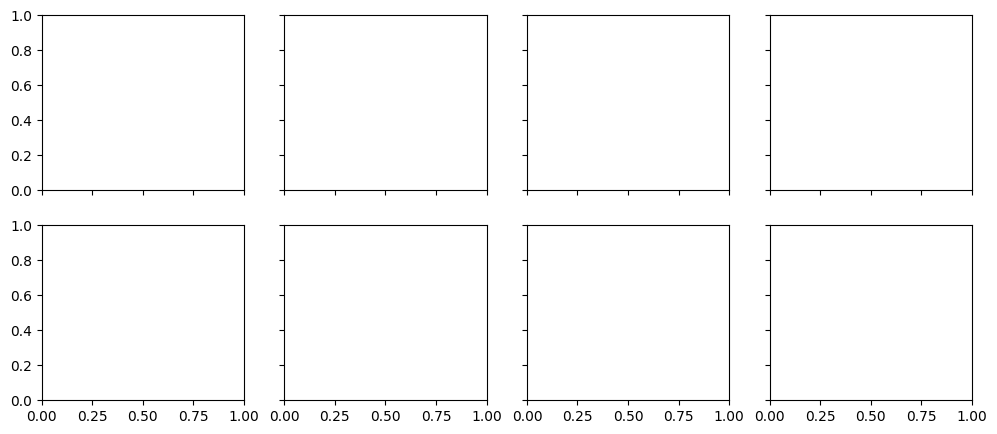

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

amro_search = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA', 'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS', 'STAPHYLOCOCCUS EPIDERMIDIS', 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

fig, ax = plt.subplots(2, 4, figsize=(12, 5), sharey=True, sharex=True)

for idx_axi, axi in enumerate(ax.flatten()):
    amro         = amro_search[idx_axi]

    grid_amro_df = pd.read_csv( os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}2.csv") ).reset_index(drop=True)
    grid_amro_df = grid_amro_df.drop_duplicates(subset=["beta", "rho"]).drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

    grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.3f}")
    grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.3f}")
    hm_crps_df   = grid_amro_df.pivot(index='beta_str', columns='rho_str', values='crps')

    sns.heatmap(ax=axi, data=np.log10(hm_crps_df), cmap='Reds')
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    axi.set_title(". ".join(amro2cute(amro).split("_")).capitalize())

ax[0, 0].set_ylabel(r'$\beta$')
ax[1, 0].set_ylabel(r'$\beta$')

for i in range(4):
    ax[1, i].set_xlabel(r'$\rho$')

fig.suptitle(r"Metapopulation $\log_{{10}}(CRPS)$ landscapes")
plt.tight_layout()


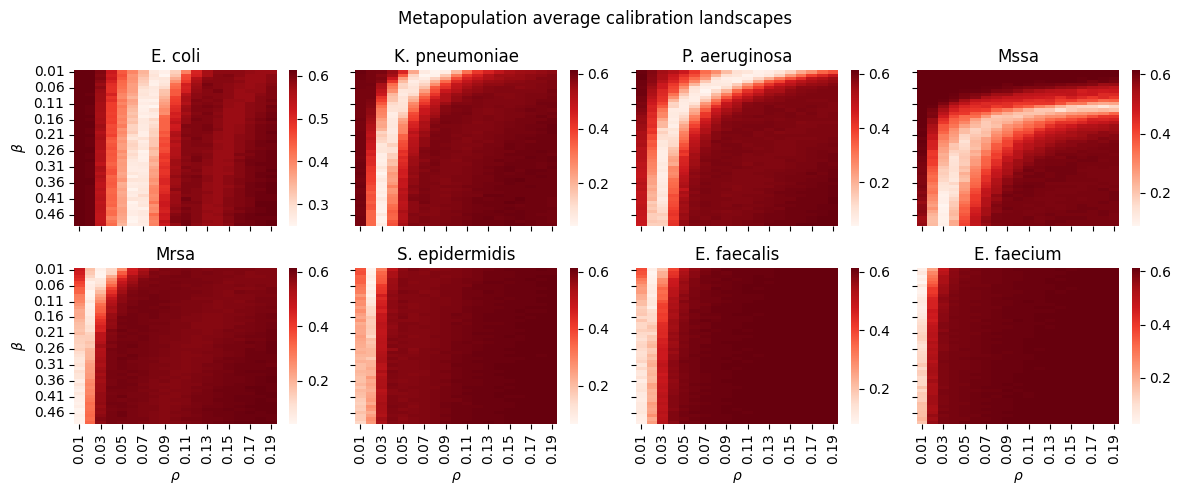

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(12, 5), sharey=True, sharex=True)

for idx_axi, axi in enumerate(ax.flatten()):
    amro         = amro_search[idx_axi]

    grid_amro_df = pd.read_csv(  os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}.csv") )
    grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.2f}")
    grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.2f}")
    hm_cov_df    = grid_amro_df.pivot(index='beta_str', columns='rho_str', values='calibration_score')

    sns.heatmap(ax=axi, data=hm_cov_df, cmap='Reds')
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    axi.set_title(". ".join(amro2cute(amro).split("_")).capitalize())

ax[0, 0].set_ylabel(r'$\beta$')
ax[1, 0].set_ylabel(r'$\beta$')

for i in range(4):
    ax[1, i].set_xlabel(r'$\rho$')

fig.suptitle("Metapopulation average calibration landscapes")
plt.tight_layout()

In [19]:
# jeff: i think we want to have 10 synthetic test per importation, with the real importations.
# me:   we could use the crps or E[calibration] to choose pairs beta, rho that fall in the 5% of lower calibration/crps ladnscape so we knew they minimize the hospital level observations.
# jeff: sure
# rami: I am not sure how do you calculate exactly credible intervals for the inference?
# jeff: First try taking it straight from the ensemble posterior distribution of a single inference.
#       It is not always great unless the inference is calibrated and can be sensitive to where in the inference you pull the solution (the end, 20 days prior).
#       Run it many times and take a range of 95% of the spread? Alternatively take the mean estimates from multiple inferences (this will likely be too narrow).
# rami: Or calculate profiles by fixing one parameter and fitting the other one, like Jaime suggested the other day.
# jeff: I don’t think this makes sense.
# rami: Is there a standard procedure for this with this type of inference?
# jeff: If well calibrated use the posterior
# rami: Also, why would the inference results come out different than the likelihood surfaces?
# jeff: Bias in the inference estimation.
# jeff: For a 2 parameter system, running LL is simple and is a brute force approach (like an MCMC).
#       As the dimension of the system increases, iterated approaches offer advantages, and the EAKF in particular is not subject to the curse of dimensionality.
# rami: And if that's the case mabe its better to work in this case with likelihood instead of EAKF?
# jeff: For the 2-parameter system it might be. But look at the credible intervals per the above.


In [ ]:

from scipy.interpolate import UnivariateSpline
def return_score_cutoff(score, cut_off_prob=0.05):
    freq, score = np.histogram(score, bins=100, density=True)
    freq_cum    = np.cumsum(freq); freq_cum = freq_cum/freq_cum[-1]
    score       = score[1:]
    f_cum       = UnivariateSpline(score, freq_cum, s=0.001)
    sc_range    = np.linspace(np.min(score), np.max(score), 1000)
    score_cut   = sc_range[np.argmin(np.abs(f_cum(sc_range) * 100 - cut_off_prob*100))]
    return score_cut

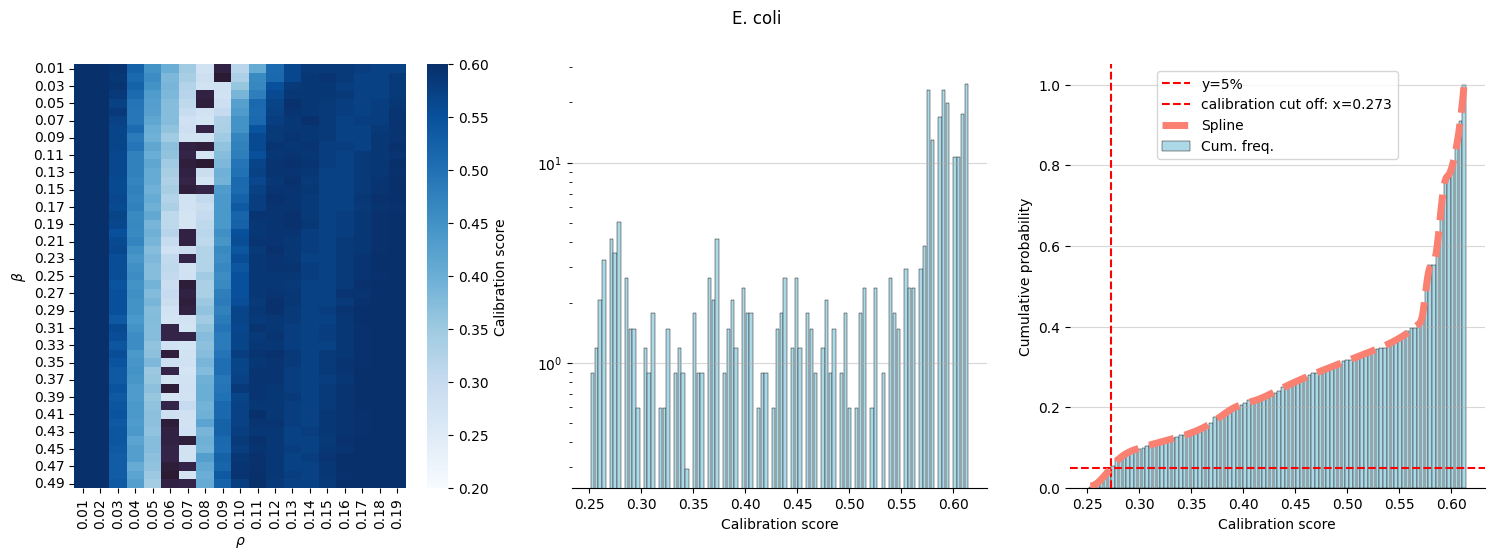

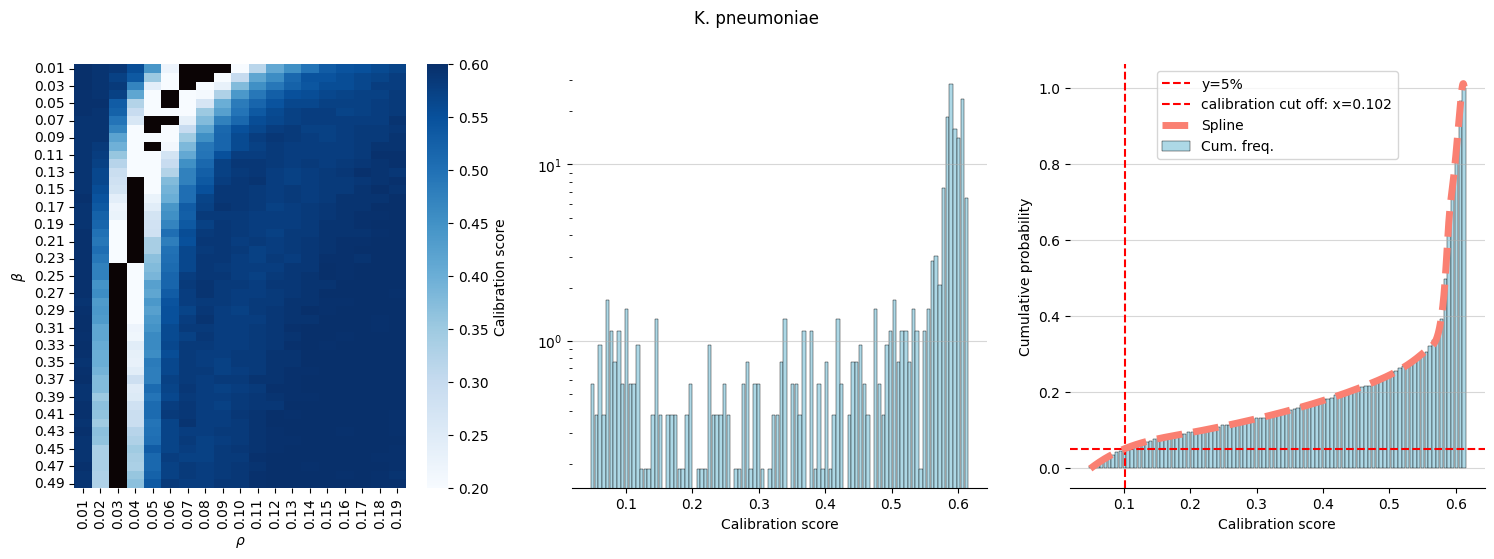

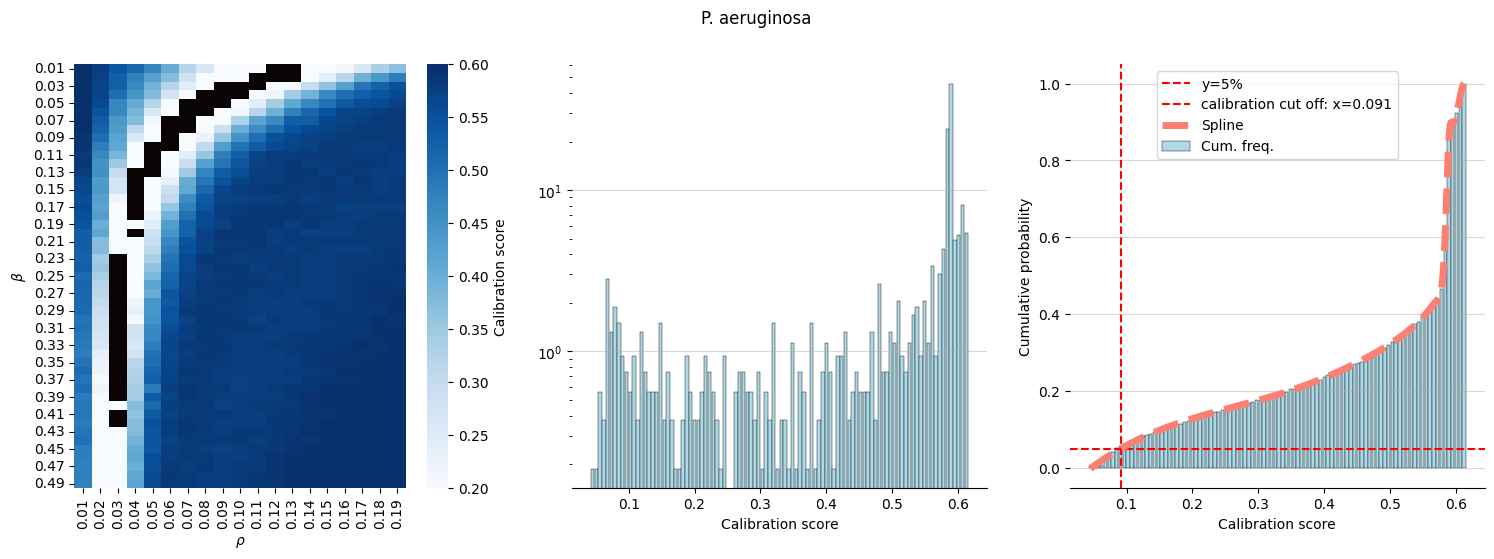

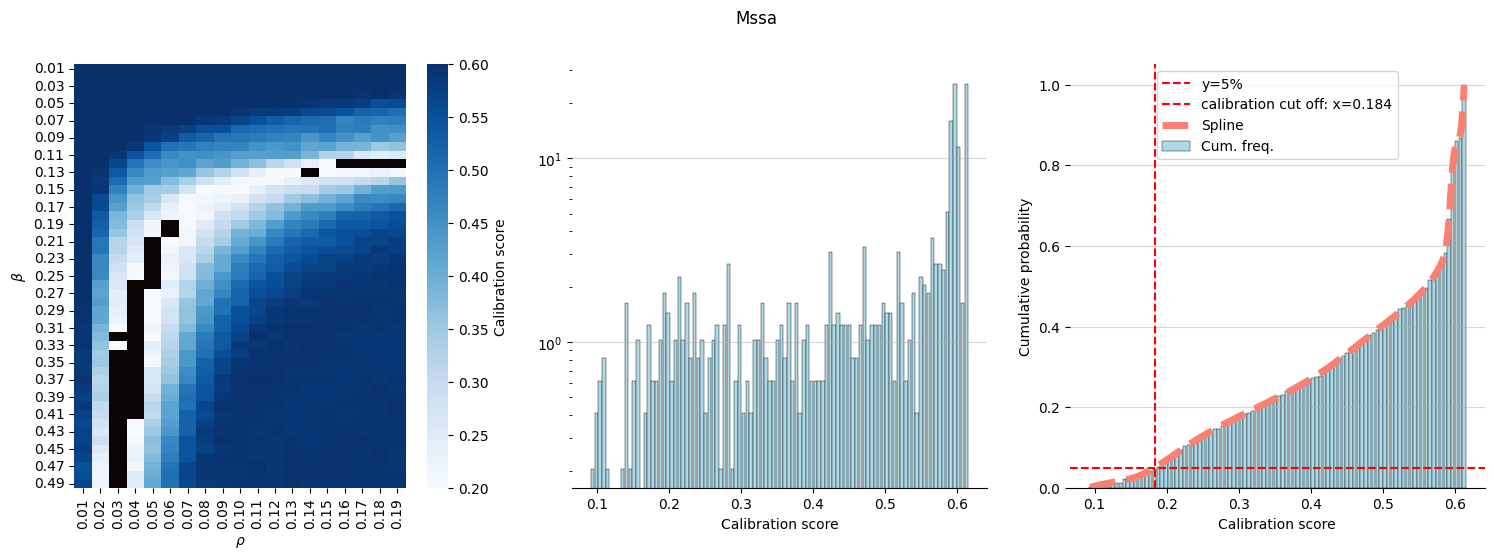

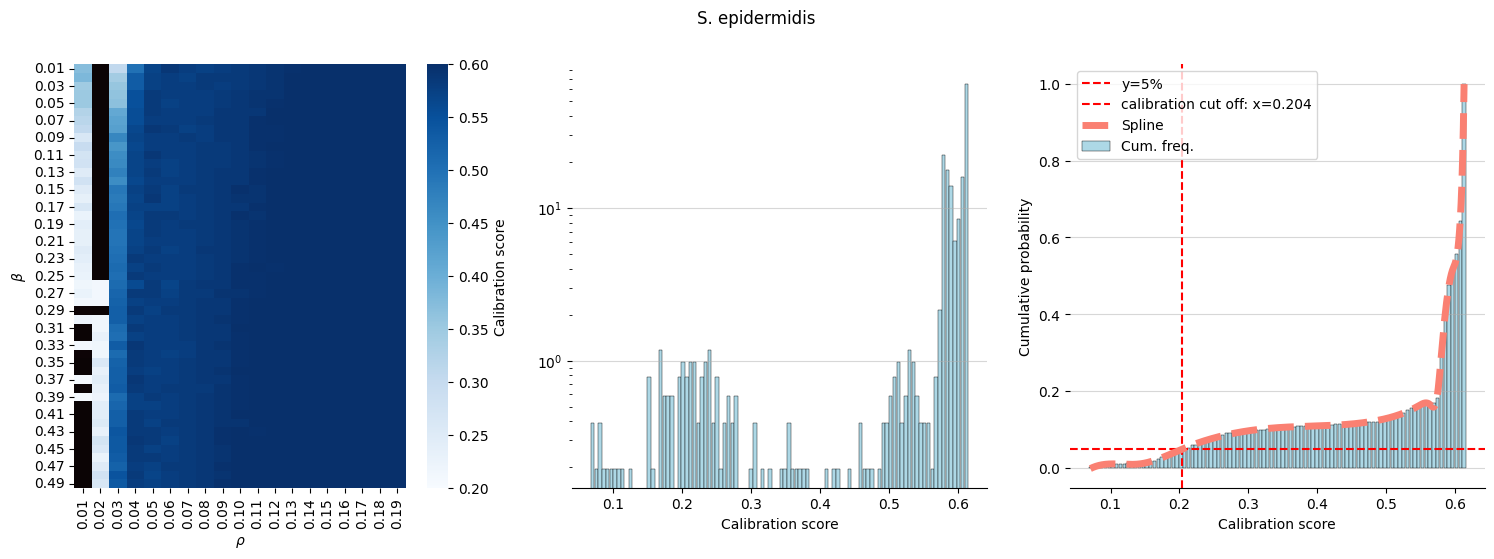

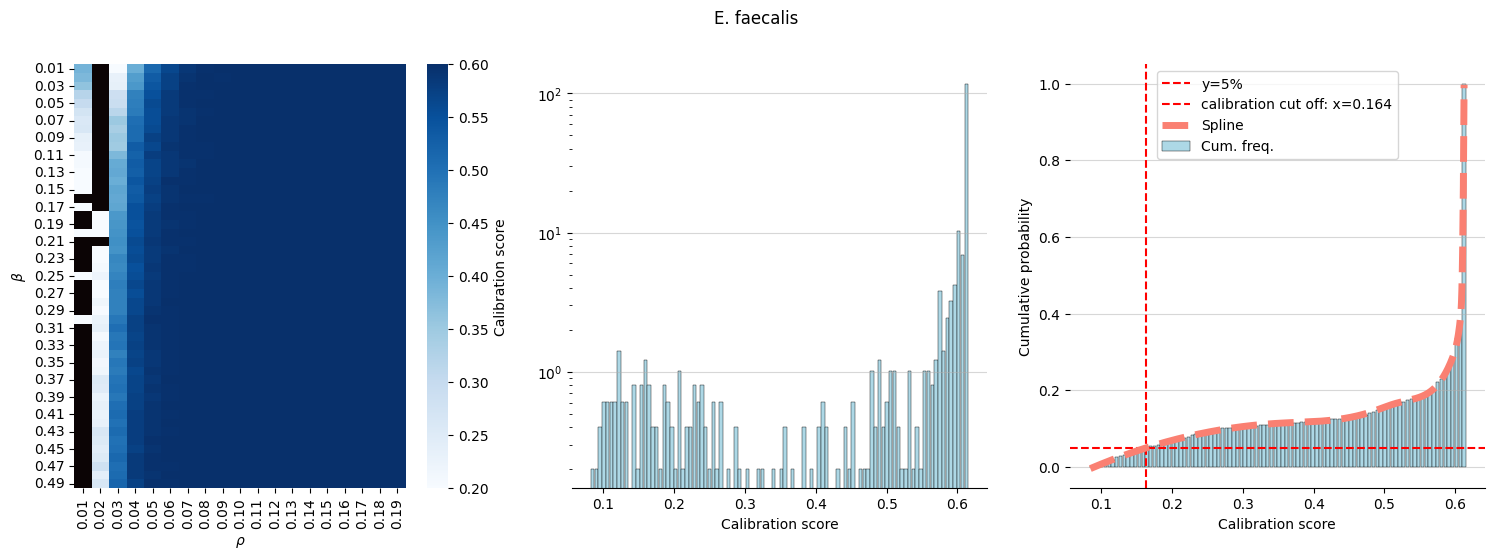

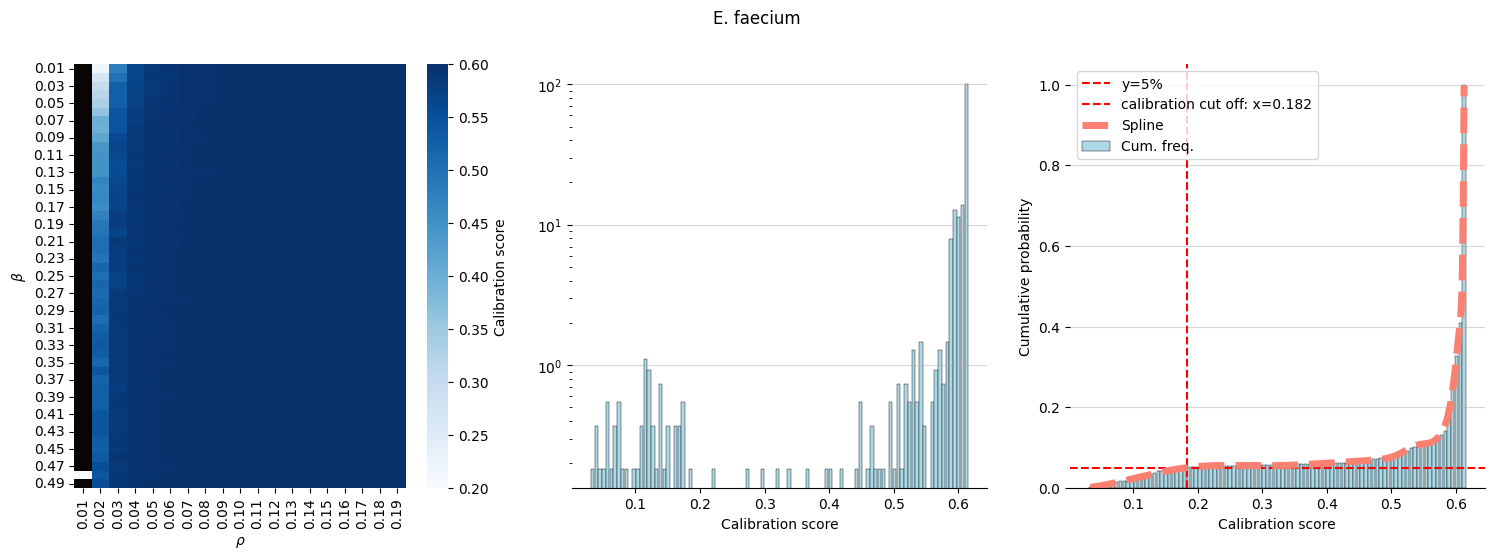

In [ ]:
import matplotlib.pyplot as plt
from misc import amro2cute
import seaborn as sns



amro_search = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

cut_off_prob = 5/100

for amro in amro_search:

    grid_amro_df             = pd.read_csv( os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}.csv") )
    grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.2f}")
    grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.2f}")

    hm_amro_df   = grid_amro_df.pivot(index='beta_str', columns='rho_str', values='calibration_score')
    freq, score = np.histogram(grid_amro_df.calibration_score, bins=100, density=True)
    freq_cum    = np.cumsum(freq); freq_cum = freq_cum/freq_cum[-1]
    score       = score[1:]
    f_cum       = UnivariateSpline(score, freq_cum, s=0.001)
    sc_range    = np.linspace(np.min(score), np.max(score), 1000)
    score_cut   = sc_range[np.argmin(np.abs(f_cum(sc_range) * 100 - cut_off_prob*100))]

    fig, ax = plt.subplots(1, 3, figsize=(18.2, 5.5))

    ax[1].bar(score, freq, align="center", width=np.min(np.diff(score))*0.9, facecolor="lightblue", edgecolor="k", lw=0.3)
    ax[1].set_xlabel("Calibration score")

    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].grid(axis='y', alpha=0.5)
    ax[1].set_yscale('log')

    ax[2].bar(score, freq_cum, align="center", width=np.min(np.diff(score))*0.9, facecolor="lightblue", edgecolor="k", lw=0.3, label="Cum. freq.")
    ax[2].axhline(y=cut_off_prob,     color='r', linestyle='--', label=f"y={int(cut_off_prob*100)}%")
    ax[2].axvline(x=score_cut, color='r', linestyle='--', label="calibration cut off: x={:.3f}".format(score_cut))
    ax[2].plot(sc_range, f_cum(sc_range), color='salmon', linestyle='--', lw=5, label="Spline")

    ax[2].set_ylabel("Cumulative probability")
    ax[2].set_xlabel("Calibration score")

    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].grid(axis='y', alpha=0.5)
    ax[2].legend()

    sns.heatmap(ax=ax[0], data=hm_amro_df, edgecolor="red", cmap='Blues', cbar_kws={'label': 'Calibration score'}, fmt=".2f", cbar=True, vmin=0.2, vmax=0.6)
    hm_amro_df[hm_amro_df > score_cut] = np.nan

    sns.heatmap(ax=ax[0], data=hm_amro_df, edgecolor="red", cmap='cool',
                    cbar_kws={'label': 'Calibration score'}, fmt=".2f", cbar=False, vmin=0.2, vmax=0.6)

    ax[0].set_ylabel(r"$\beta$")
    ax[0].set_xlabel(r"$\rho$")

    fig.suptitle("{}".format(". ".join(amro2cute(amro).split("_")).capitalize()))


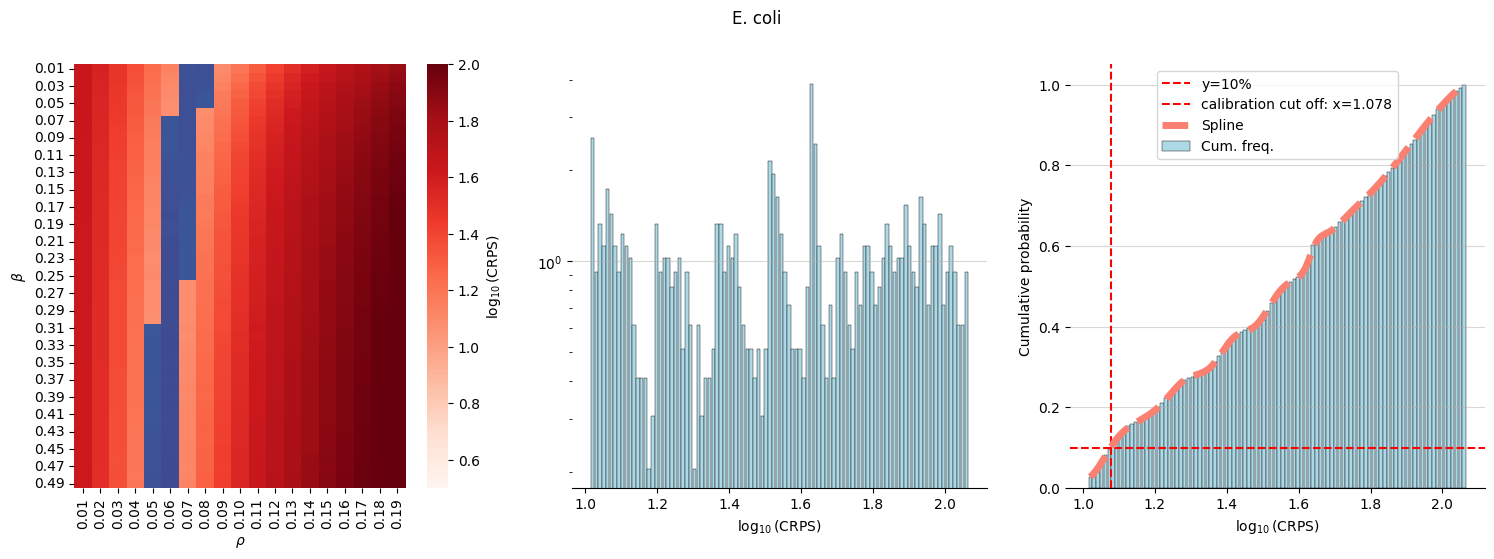

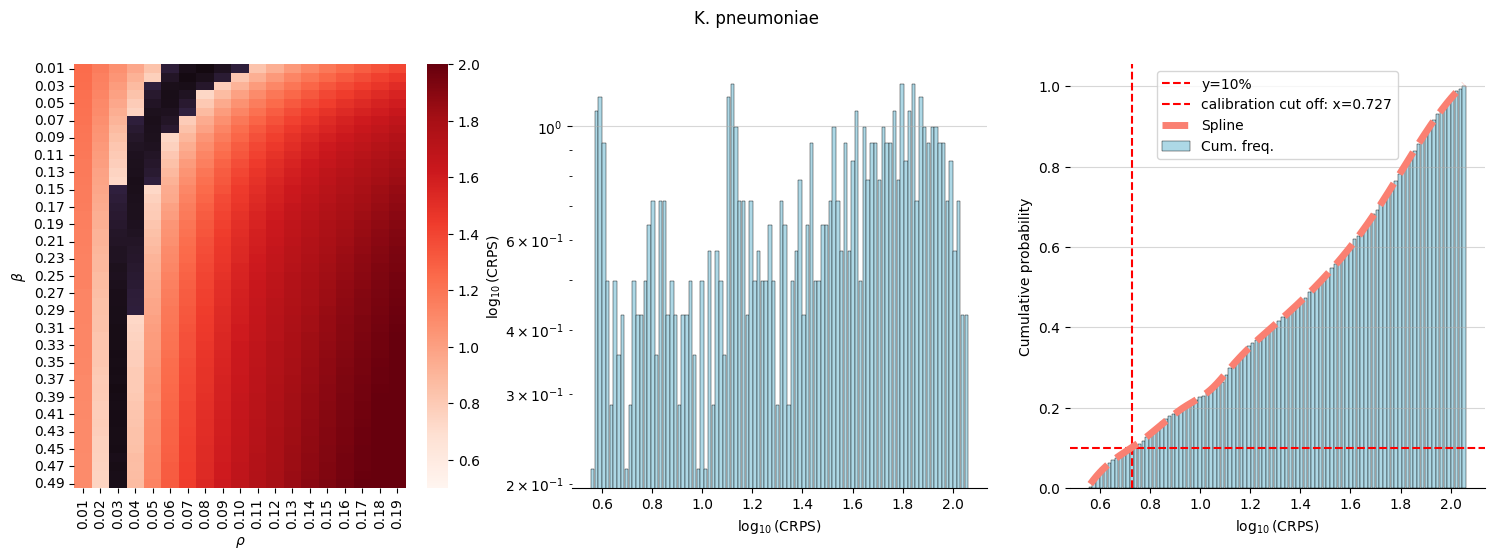

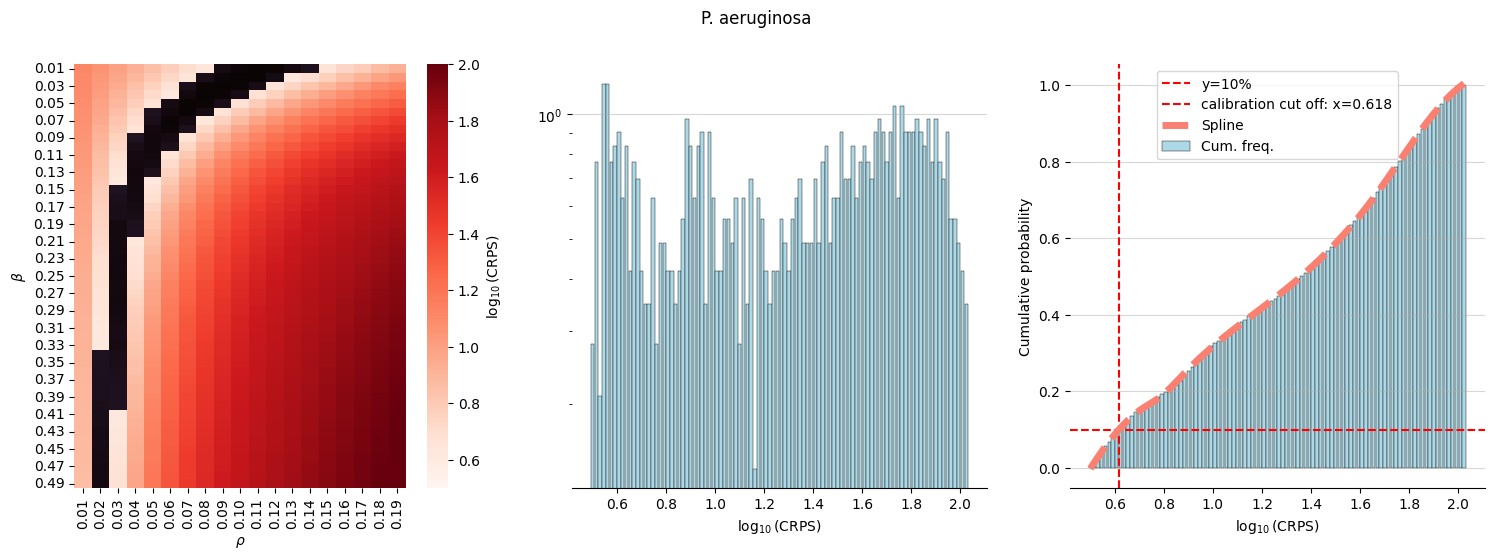

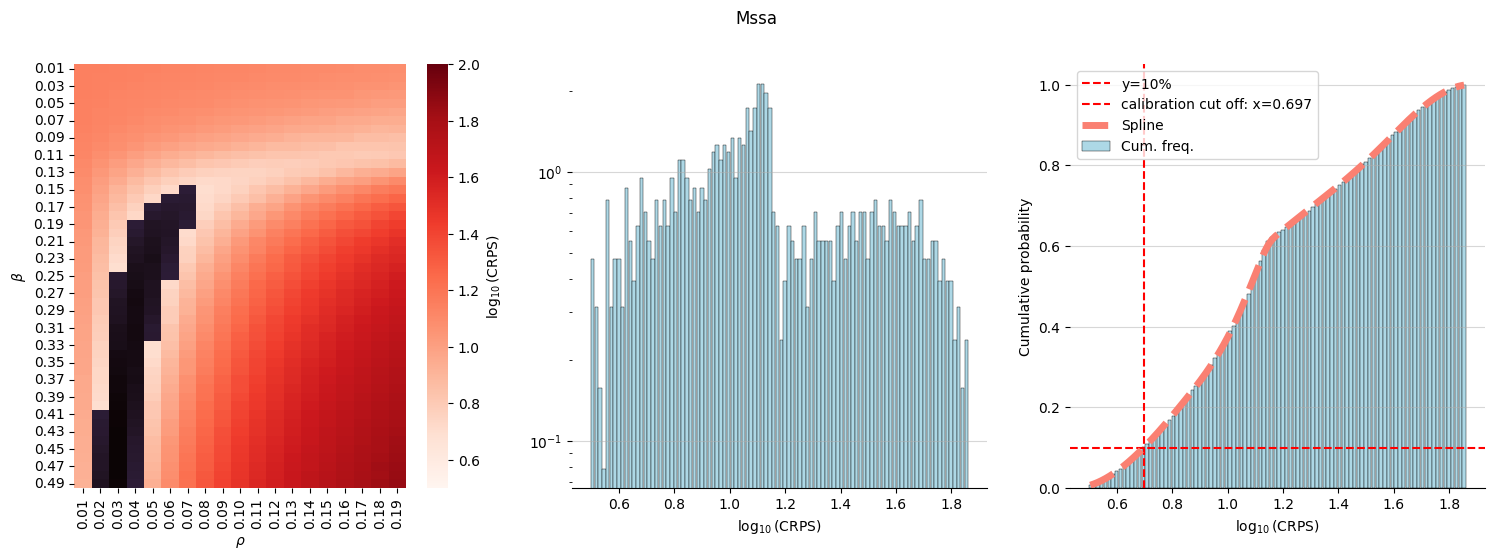

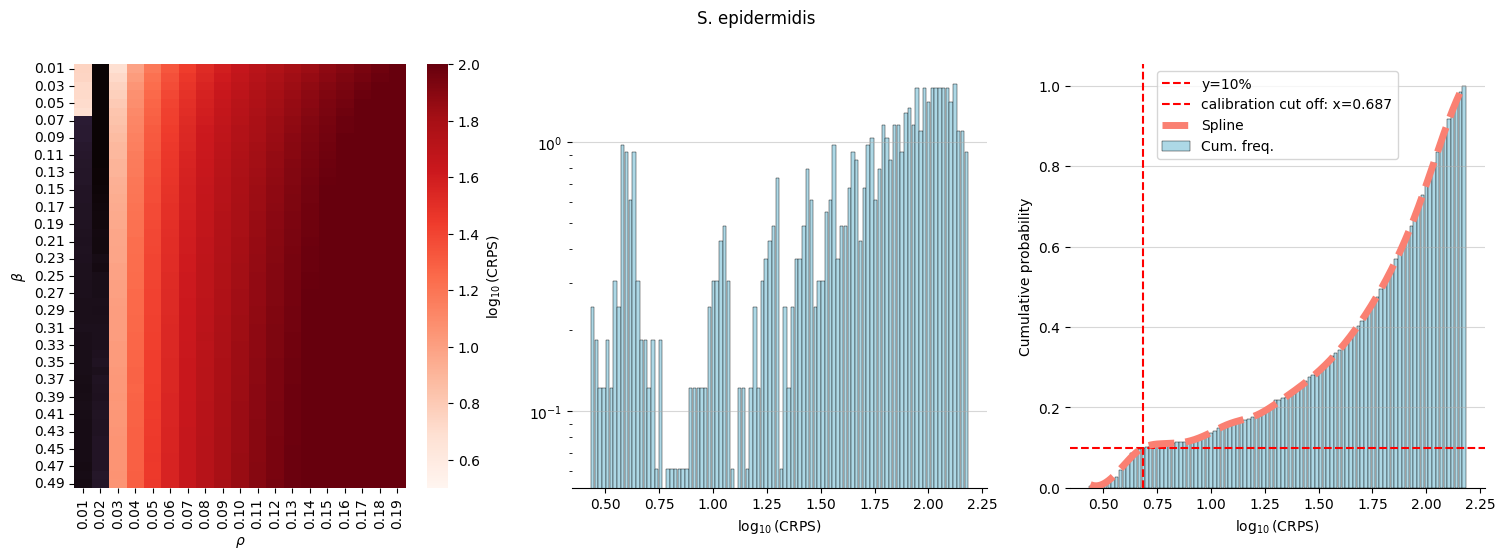

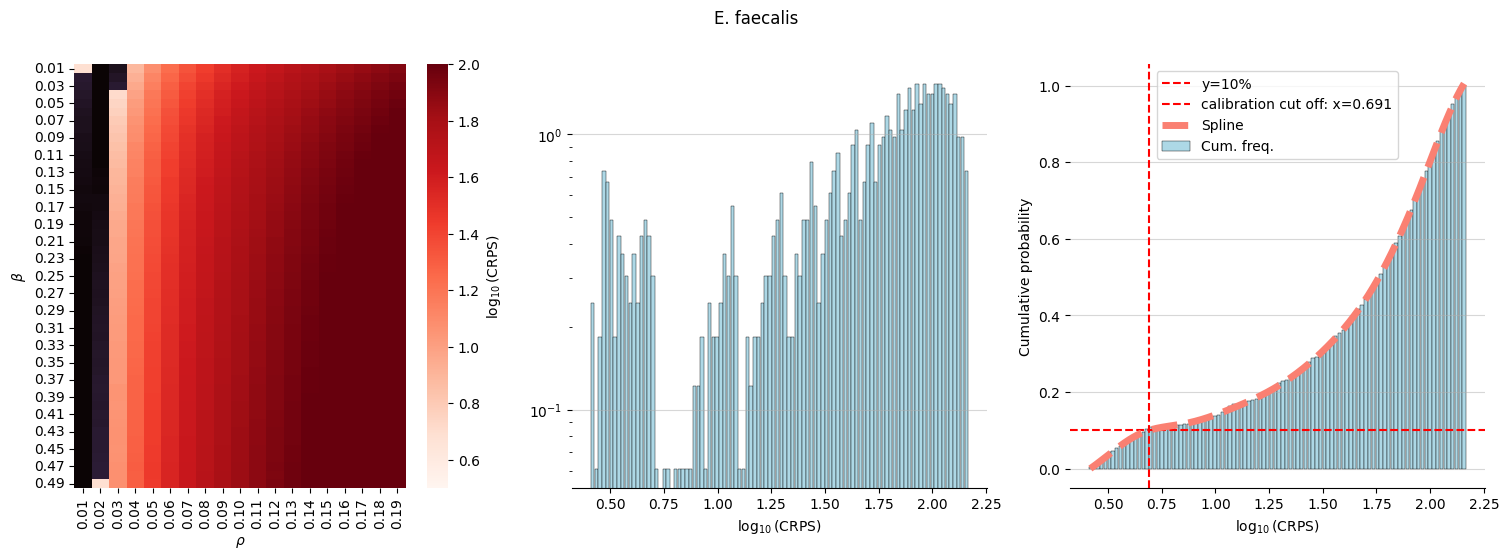

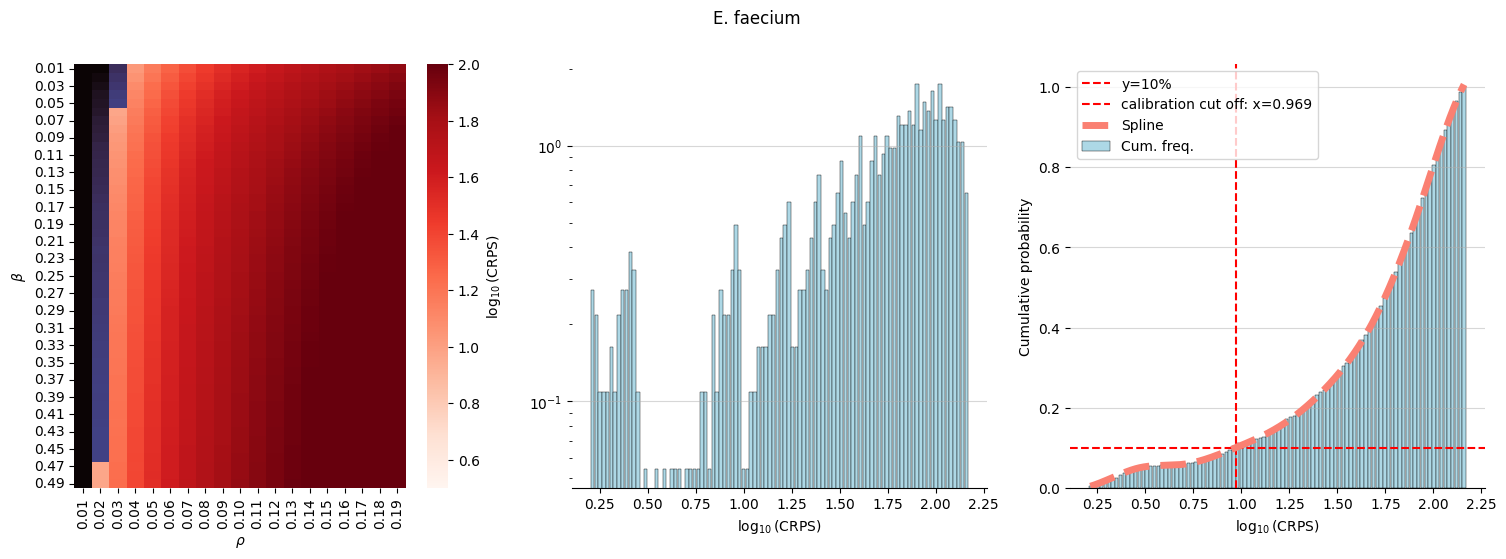

In [ ]:
import matplotlib.pyplot as plt
from misc import amro2cute
import seaborn as sns



amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

cut_off_prob = 10 / 100

for amro in amro_search:

    grid_amro_df             = pd.read_csv( os.path.join(results2_dir, "grid_search", "metapopulation", f"{amro2cute(amro)}.csv") )
    grid_amro_df["beta_str"] = grid_amro_df.beta.apply(lambda x: f"{x:.2f}")
    grid_amro_df["rho_str"]  = grid_amro_df.rho.apply(lambda x: f"{x:.2f}")
    grid_amro_df["crps"]     = np.log10(grid_amro_df.crps)

    hm_amro_df   = grid_amro_df.pivot(index='beta_str', columns='rho_str', values='crps')

    freq, score = np.histogram(grid_amro_df.crps, bins=100, density=True)
    freq_cum    = np.cumsum(freq); freq_cum = freq_cum/freq_cum[-1]
    score       = score[1:]
    f_cum       = UnivariateSpline(score, freq_cum, s=0.001)
    sc_range    = np.linspace(np.min(score), np.max(score), 1000)
    score_cut   = sc_range[np.argmin(np.abs(f_cum(sc_range) * 100 - cut_off_prob*100))]

    fig, ax = plt.subplots(1, 3, figsize=(18.2, 5.5))

    ax[1].bar(score, freq, align="center", width=np.min(np.diff(score))*0.9, facecolor="lightblue", edgecolor="k", lw=0.3)
    ax[1].set_xlabel(r"$\log_{{10}}$(CRPS)")

    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].grid(axis='y', alpha=0.5)
    ax[1].set_yscale('log')

    ax[2].bar(score, freq_cum, align="center", width=np.min(np.diff(score))*0.9, facecolor="lightblue", edgecolor="k", lw=0.3, label="Cum. freq.")
    ax[2].axhline(y=cut_off_prob,     color='r', linestyle='--', label=f"y={int(cut_off_prob*100)}%")
    ax[2].axvline(x=score_cut, color='r', linestyle='--', label="calibration cut off: x={:.3f}".format(score_cut))
    ax[2].plot(sc_range, f_cum(sc_range), color='salmon', linestyle='--', lw=5, label="Spline")

    ax[2].set_ylabel("Cumulative probability")
    ax[2].set_xlabel(r"$\log_{{10}}$(CRPS)")

    ax[2].spines['right'].set_visible(False)
    ax[2].spines['left'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].grid(axis='y', alpha=0.5)
    ax[2].legend()

    sns.heatmap(ax=ax[0], data=hm_amro_df, edgecolor="red", cmap='Reds', cbar_kws={'label': r"$\log_{{10}}$(CRPS)"}, fmt=".2f", cbar=True, vmin=0.5, vmax=2)
    hm_amro_df[hm_amro_df > score_cut] = np.nan

    sns.heatmap(ax=ax[0], data=hm_amro_df, edgecolor="red", cmap='cool',
                    cbar_kws={'label': 'Calibration score'}, fmt=".2f", cbar=False, vmin=0.5, vmax=2)

    ax[0].set_ylabel(r"$\beta$")
    ax[0].set_xlabel(r"$\rho$")

    fig.suptitle("{}".format(". ".join(amro2cute(amro).split("_")).capitalize()))

